In [15]:
!pip install --upgrade transformers
!pip install mysql-connector-python
!pip install sentencepiece
!pip install protobuf

^C


SQL CONNECTION

In [1]:
import mysql.connector

connection = mysql.connector.connect(
  host = "gateway01.ap-southeast-1.prod.aws.tidbcloud.com",
  port = 4000,
  user = "38pAbRBz5Urzj3r.root",
  password = "dXIP2LwlYh0vkTdH",
  database = "equipment_profile",
  ssl_ca = "/etc/ssl/cert.pem",
  ssl_verify_cert = True,
  ssl_verify_identity = True
)
if connection.is_connected():
    print("✅ Connected to TiDB successfully!")
else:
    print("❌ Failed to connect to TiDB")


✅ Connected to TiDB successfully!


Create Vector from MODEL

In [9]:
from transformers import AutoModel, AutoProcessor

processor = AutoProcessor.from_pretrained("google/siglip-base-patch16-224")
model = AutoModel.from_pretrained("google/siglip-base-patch16-224")

/Users/sedtawutchalothornnarumit/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [4]:
import os
from PIL import Image
import torch
import numpy as np
import json
from sklearn.model_selection import train_test_split

In [55]:
def process_multi_class_dataset(dataset_path="dataset/"):
    """
    Process multiple classes from different folders without train/validation split.
    """
    all_train_embeddings = []
    
    # Get all class folders
    class_folders = [f for f in os.listdir(dataset_path) 
                    if os.path.isdir(os.path.join(dataset_path, f))]
    
    print(f"Found {len(class_folders)} classes: {class_folders}")
    
    for class_name in class_folders:
        folder_path = os.path.join(dataset_path, class_name)
        print(f"\n📁 Processing class: {class_name}")
        
        # Get all image files for this class
        image_files = []
        for filename in os.listdir(folder_path):
            if filename.lower().endswith((".jpeg", ".jpg", ".png", ".webp")):
                image_files.append(filename)
        
        if len(image_files) == 0:
            print(f"⚠️ No images found in {folder_path}")
            continue
            
        print(f"Total images found: {len(image_files)}")
        
        # Process all files for this class
        class_train_embeddings = []
        for filename in image_files:
            path = os.path.join(folder_path, filename)
            try:
                image = Image.open(path)
                
                # Generate embedding for the image
                inputs = processor(images=image, return_tensors="pt")
                with torch.no_grad():
                    outputs = model.get_image_features(**inputs)
                
                embedding = outputs / outputs.norm(p=2, dim=-1, keepdim=True)  # normalize
                
                # Append embedding with label and file path
                class_train_embeddings.append({
                    "embedding": embedding.squeeze().tolist(),
                    "label": class_name,
                    "file_path": path
                })
            except Exception as e:
                print(f"❌ Error processing file {filename}: {e}")
        
        # Add to overall collection
        all_train_embeddings.extend(class_train_embeddings)
        
        # Calculate summary statistics for this class
        if class_train_embeddings:
            class_train_summary = np.mean([item["embedding"] for item in class_train_embeddings], axis=0)
            print(f"✅ {class_name} processed: {len(class_train_embeddings)} embeddings")
    
    print(f"\n🎯 Overall Summary:")
    print(f"Total classes processed: {len(class_folders)}")
    print(f"Total embeddings: {len(all_train_embeddings)}")
    
    return all_train_embeddings

# Process all classes
print("🚀 Starting multi-class dataset processing...")
train_embeddings = process_multi_class_dataset(dataset_path="dataset/equipment_train")

# Show class distribution
if train_embeddings:
    train_class_counts = {}
    for emb in train_embeddings:
        label = emb["label"]
        train_class_counts[label] = train_class_counts.get(label, 0) + 1
    
    print(f"\n📊 Class distribution:")
    for class_name, count in train_class_counts.items():
        print(f"  {class_name}: {count} images")


🚀 Starting multi-class dataset processing...
Found 21 classes: ['AI22', 'AI8', 'AI6', 'AI13', 'AI1', 'AI14', 'AI15', 'AI7', 'AI12', 'AI9', 'AI19', 'AI21', 'AI2', 'AI17', 'AI5', 'AI10', 'AI4', 'AI11', 'AI3', 'AI16', 'AI18']

📁 Processing class: AI22
Total images found: 71
✅ AI22 processed: 71 embeddings

📁 Processing class: AI8
Total images found: 87
✅ AI8 processed: 87 embeddings

📁 Processing class: AI6
Total images found: 82
✅ AI6 processed: 82 embeddings

📁 Processing class: AI13
Total images found: 81
✅ AI13 processed: 81 embeddings

📁 Processing class: AI1
Total images found: 100
✅ AI1 processed: 100 embeddings

📁 Processing class: AI14
Total images found: 79
✅ AI14 processed: 79 embeddings

📁 Processing class: AI15
Total images found: 132
✅ AI15 processed: 132 embeddings

📁 Processing class: AI7
Total images found: 89
✅ AI7 processed: 89 embeddings

📁 Processing class: AI12
Total images found: 73
✅ AI12 processed: 73 embeddings

📁 Processing class: AI9
Total images found: 129
✅ A

Save on vector db

In [58]:
# Create cursor for database operations
cursor = connection.cursor()

# Clear previous data (optional - remove this if you want to keep existing data)
# cursor.execute("DELETE FROM equipment_embeddings")
# print("🗑️ Cleared existing embeddings from database")

# Only save training embeddings to the database
train_count_by_class = {}
total_train_count = 0

print("💾 Saving training embeddings to database...")

for idx, embedding in enumerate(train_embeddings):
    # Extract the embedding, label, and file path
    embedding_list = embedding["embedding"]
    label = embedding["label"]
    file_path = embedding["file_path"]

    # Insert the embedding into the database
    insert_query = """
    INSERT INTO equipment_embeddings (class_name, image_embedding, path) 
    VALUES (%s, %s, %s)
    """

    # Convert embedding to JSON string
    embedding_json = json.dumps(embedding_list)

    # Execute the insert
    cursor.execute(insert_query, (label, embedding_json, file_path))
    
    # Count by class
    train_count_by_class[label] = train_count_by_class.get(label, 0) + 1
    total_train_count += 1
    
    # Show progress every 50 embeddings
    if (idx + 1) % 50 == 0:
        print(f"Progress: {idx + 1}/{len(train_embeddings)} embeddings saved")

# Commit the transaction
connection.commit()

print(f"\n✅ Training embeddings saved to database successfully!")
print(f"Total training embeddings saved: {total_train_count}")

print(f"\n📊 Training embeddings saved by class:")
for class_name, count in train_count_by_class.items():
    print(f"  {class_name}: {count} embeddings")

💾 Saving training embeddings to database...
Progress: 50/2107 embeddings saved
Progress: 100/2107 embeddings saved
Progress: 150/2107 embeddings saved
Progress: 200/2107 embeddings saved
Progress: 250/2107 embeddings saved
Progress: 300/2107 embeddings saved
Progress: 350/2107 embeddings saved
Progress: 400/2107 embeddings saved
Progress: 450/2107 embeddings saved
Progress: 500/2107 embeddings saved
Progress: 550/2107 embeddings saved
Progress: 600/2107 embeddings saved
Progress: 650/2107 embeddings saved
Progress: 700/2107 embeddings saved
Progress: 750/2107 embeddings saved
Progress: 800/2107 embeddings saved
Progress: 850/2107 embeddings saved
Progress: 900/2107 embeddings saved
Progress: 950/2107 embeddings saved
Progress: 1000/2107 embeddings saved
Progress: 1050/2107 embeddings saved
Progress: 1100/2107 embeddings saved
Progress: 1150/2107 embeddings saved
Progress: 1200/2107 embeddings saved
Progress: 1250/2107 embeddings saved
Progress: 1300/2107 embeddings saved
Progress: 1350

Evaluation Functions

In [66]:
def process_testset(dataset_path="equipment_test/"):
    """
    Process test set images from different folders.
    """
    test_embeddings = []
    
    # Get all class folders
    class_folders = [f for f in os.listdir(dataset_path) 
                    if os.path.isdir(os.path.join(dataset_path, f))]
    
    print(f"Found {len(class_folders)} classes in test set: {class_folders}")
    
    for class_name in class_folders:
        folder_path = os.path.join(dataset_path, class_name)
        print(f"\n📁 Processing class: {class_name}")
        
        # Get all image files for this class
        image_files = []
        for filename in os.listdir(folder_path):
            if filename.lower().endswith((".jpeg", ".jpg", ".png", ".webp")):
                image_files.append(filename)
        
        if len(image_files) == 0:
            print(f"⚠️ No images found in {folder_path}")
            continue
            
        print(f"Total images found: {len(image_files)}")
        
        # Process all files for this class
        for filename in image_files:
            path = os.path.join(folder_path, filename)
            try:
                image = Image.open(path)
                
                # Generate embedding for the image
                inputs = processor(images=image, return_tensors="pt")
                with torch.no_grad():
                    outputs = model.get_image_features(**inputs)
                
                embedding = outputs / outputs.norm(p=2, dim=-1, keepdim=True)  # normalize
                
                # Append embedding with label and file path
                test_embeddings.append({
                    "embedding": embedding.squeeze().tolist(),
                    "label": class_name,
                    "file_path": path
                })
            except Exception as e:
                print(f"❌ Error processing file {filename}: {e}")
    
    print(f"\n🎯 Test Set Summary:")
    print(f"Total classes processed: {len(class_folders)}")
    print(f"Total embeddings: {len(test_embeddings)}")
    
    return test_embeddings

# Process the test set
print("🚀 Starting test set processing...")
val_embeddings = process_testset(dataset_path="dataset/equipment_test")


🚀 Starting test set processing...
Found 21 classes in test set: ['AI22', 'AI8', 'AI6', 'AI13', 'AI1', 'AI14', 'AI15', 'AI7', 'AI12', 'AI9', 'AI19', 'AI21', 'AI2', 'AI17', 'AI5', 'AI10', 'AI4', 'AI11', 'AI3', 'AI16', 'AI18']

📁 Processing class: AI22
Total images found: 18

📁 Processing class: AI8
Total images found: 22


KeyboardInterrupt: 

In [70]:
def evaluate_model_on_validation(val_embeddings, connection, top_k=5):
    """
    Evaluate the model using validation embeddings.
    This function tests how well the model can retrieve similar images from the database
    using validation set images as queries.
    """
    correct_predictions = 0
    total_predictions = len(val_embeddings)
    
    print(f"🔍 Evaluating model on {total_predictions} validation images...")
    
    for i, val_embedding in enumerate(val_embeddings):
        # Use the validation embedding as a query
        query_embedding = val_embedding["embedding"]
        true_label = val_embedding["label"]
        
        # Search in the database (which only contains training data)
        cur = connection.cursor()
        sql = """
        SELECT class_name, path, 
               vec_cosine_distance(image_embedding, %s) AS distance
        FROM equipment_embeddings
        ORDER BY distance ASC
        LIMIT %s;
        """
        cur.execute(sql, (json.dumps(query_embedding), top_k))
        results = cur.fetchall()
        cur.close()
        
        # Check if the top result matches the true label
        if results and results[0][0] == true_label:
            correct_predictions += 1
        
        # Print progress every 50 images
        if (i + 1) % 50 == 0:
            print(f"Progress: {i + 1}/{total_predictions}")
    
    # Calculate accuracy
    accuracy = correct_predictions / total_predictions * 100
    
    print(f"\n📈 Evaluation Results:")
    print(f"Correct predictions: {correct_predictions}/{total_predictions}")
    print(f"Accuracy: {accuracy:.2f}%")
    
    return accuracy, correct_predictions, total_predictions

def evaluate_single_validation_image(val_embedding, connection, top_k=5, show_results=True):
    """
    Evaluate a single validation image and optionally show the top-k results.
    """
    query_embedding = val_embedding["embedding"]
    true_label = val_embedding["label"]
    true_path = val_embedding["file_path"]
    
    # Search in the database
    cur = connection.cursor()
    sql = """
    SELECT class_name, path, 
           vec_cosine_distance(image_embedding, %s) AS distance
    FROM equipment_embeddings
    ORDER BY distance ASC
    LIMIT %s;
    """
    cur.execute(sql, (json.dumps(query_embedding), top_k))
    results = cur.fetchall()
    cur.close()
    
    if show_results:
        print(f"🔍 Query image: {true_path} (True label: {true_label})")
        print(f"Top {top_k} similar images from training set:")
        for i, (class_name, path, distance) in enumerate(results, 1):
            print(f"{i}. {class_name} - {path} (Distance: {distance:.4f})")
        
        # Check if prediction is correct
        if results and results[0][0] == true_label:
            print("✅ Correct prediction!")
        else:
            print("❌ Incorrect prediction!")
    
    return results

In [61]:
# Example: Evaluate on a random validation image
if val_embeddings:
    import random
    random_val_image = random.choice(val_embeddings)
    print("📝 Example evaluation on a random validation image:")
    evaluate_single_validation_image(random_val_image, connection)

📝 Example evaluation on a random validation image:
🔍 Query image: dataset/equipment_test/AI8/20251112_105734.jpg (True label: AI8)
Top 5 similar images from training set:
1. AI8 - dataset/equipment_train/AI8/20251112_105737.jpg (Distance: 0.0172)
2. AI8 - dataset/equipment_train/AI8/20251112_105735.jpg (Distance: 0.0228)
3. AI8 - dataset/equipment_train/AI8/20251112_105738.jpg (Distance: 0.0253)
4. AI8 - dataset/equipment_train/AI8/20251112_105645.jpg (Distance: 0.0351)
5. AI8 - dataset/equipment_train/AI8/20251112_105647.jpg (Distance: 0.0354)
✅ Correct prediction!


In [71]:
# Run full evaluation on multi-class validation set
if val_embeddings:
    print("🚀 Running full multi-class validation evaluation...")
    accuracy, correct, total = evaluate_model_on_validation(val_embeddings, connection, top_k=5)
    
    # Calculate per-class accuracy
    class_correct = {}
    class_total = {}
    class_accuracy = {}
    
    print(f"\n🔍 Calculating per-class accuracy...")
    
    for val_embedding in val_embeddings:
        query_embedding = val_embedding["embedding"]
        true_label = val_embedding["label"]
        
        # Initialize counters
        if true_label not in class_total:
            class_total[true_label] = 0
            class_correct[true_label] = 0
        
        class_total[true_label] += 1
        
        # Search in the database
        cur = connection.cursor()
        sql = """
        SELECT class_name, path, 
               vec_cosine_distance(image_embedding, %s) AS distance
        FROM equipment_embeddings
        ORDER BY distance ASC
        LIMIT 1;
        """
        cur.execute(sql, (json.dumps(query_embedding),))
        result = cur.fetchone()
        cur.close()
        
        if result and result[0] == true_label:
            class_correct[true_label] += 1
    
    # Calculate per-class accuracy
    for class_name in class_total:
        class_accuracy[class_name] = (class_correct[class_name] / class_total[class_name]) * 100
    
    print(f"\n🎯 Final Multi-Class Evaluation Summary:")
    print(f"Overall validation accuracy: {accuracy:.2f}%")
    print(f"Overall correct predictions: {correct}/{total}")
    
    print(f"\n📊 Per-Class Results:")
    for class_name in sorted(class_accuracy.keys()):
        acc = class_accuracy[class_name]
        print(f"  {class_name}: {acc:.2f}% ({class_correct[class_name]}/{class_total[class_name]})")
    
    # Overall performance assessment
    print(f"\n🏆 Performance Assessment:")
    if accuracy >= 90:
        print("🏆 Excellent overall performance!")
    elif accuracy >= 70:
        print("👍 Good overall performance!")
    elif accuracy >= 50:
        print("⚠️ Average performance - consider model improvements")
    else:
        print("🔴 Poor performance - needs significant improvement")
    
    # Find best and worst performing classes
    if class_accuracy:
        best_class = max(class_accuracy, key=class_accuracy.get)
        worst_class = min(class_accuracy, key=class_accuracy.get)
        
        print(f"\n📈 Class Performance:")
        print(f"Best performing: {best_class} ({class_accuracy[best_class]:.2f}%)")
        print(f"Worst performing: {worst_class} ({class_accuracy[worst_class]:.2f}%)")
        
        # Show which classes might be confused
        print(f"\n🔄 Classes to investigate:")
        for class_name, acc in class_accuracy.items():
            if acc < 80:
                print(f"  {class_name}: {acc:.2f}% - may need more training data or better features")
    
else:
    print("❌ No validation embeddings available for evaluation")

🚀 Running full multi-class validation evaluation...
🔍 Evaluating model on 537 validation images...
Progress: 50/537
Progress: 100/537
Progress: 150/537
Progress: 200/537
Progress: 250/537
Progress: 300/537
Progress: 350/537
Progress: 400/537
Progress: 450/537
Progress: 500/537

📈 Evaluation Results:
Correct predictions: 537/537
Accuracy: 100.00%

🔍 Calculating per-class accuracy...

🎯 Final Multi-Class Evaluation Summary:
Overall validation accuracy: 100.00%
Overall correct predictions: 537/537

📊 Per-Class Results:
  AI1: 100.00% (26/26)
  AI10: 100.00% (28/28)
  AI11: 100.00% (16/16)
  AI12: 100.00% (19/19)
  AI13: 100.00% (21/21)
  AI14: 100.00% (20/20)
  AI15: 100.00% (33/33)
  AI16: 100.00% (22/22)
  AI17: 100.00% (21/21)
  AI18: 100.00% (26/26)
  AI19: 100.00% (40/40)
  AI2: 100.00% (42/42)
  AI21: 100.00% (20/20)
  AI22: 100.00% (18/18)
  AI3: 100.00% (26/26)
  AI4: 100.00% (33/33)
  AI5: 100.00% (27/27)
  AI6: 100.00% (21/21)
  AI7: 100.00% (23/23)
  AI8: 100.00% (22/22)
  AI9:

Search Unseen Image Functions

In [7]:
def search_similar_images_from_path(image_path, connection, top_k=5, show_image=True, show_results=True):
    """
    Search for similar images in the database using an image file path.
    
    Args:
        image_path (str): Path to the query image file
        connection: Database connection object
        top_k (int): Number of similar images to return
        show_image (bool): Whether to display the query image
        show_results (bool): Whether to print the results
    
    Returns:
        list: List of tuples (class_name, path, distance)
    """
    try:
        # Load and display the query image
        image = Image.open(image_path)
        
        if show_image:
            import matplotlib.pyplot as plt
            plt.figure(figsize=(8, 6))
            plt.imshow(image)
            plt.axis('off')
            plt.title(f"Query Image: {os.path.basename(image_path)}")
            plt.show()
        
        # Generate embedding for the query image
        inputs = processor(images=image, return_tensors="pt")
        with torch.no_grad():
            query_embedding = model.get_image_features(**inputs)
        
        # Normalize the embedding
        query_embedding = query_embedding / query_embedding.norm(p=2, dim=-1, keepdim=True)
        query_embedding_list = query_embedding.squeeze().tolist()

        # Search in the database
        cur = connection.cursor()
        sql = """
        SELECT class_name, path, 
               vec_cosine_distance(image_embedding, %s) AS distance
        FROM equipment_embeddings
        ORDER BY distance ASC
        LIMIT %s;
        """
        cur.execute(sql, (json.dumps(query_embedding_list), top_k))
        results = cur.fetchall()
        cur.close()

        if show_results:
            print(f"🔍 Query: {image_path}")
            print(f"📊 Top {top_k} similar images:")
            print("-" * 60)
            
            for i, (class_name, path, distance) in enumerate(results, 1):
                confidence = (1 - distance) * 100  # Convert distance to confidence percentage
                print(f"{i}. Class: {class_name}")
                print(f"   Path: {path}")
                print(f"   Confidence: {confidence:.2f}% (Distance: {distance:.4f})")
                print()
            
            # Show prediction
            if results:
                predicted_class = results[0][0]
                confidence = (1 - results[0][2]) * 100
                print(f"🎯 Predicted Class: {predicted_class} (Confidence: {confidence:.2f}%)")
            else:
                print("❌ No similar images found in database")

        return [(class_name, path, distance) for class_name, path, distance in results]
        
    except Exception as e:
        print(f"❌ Error processing image {image_path}: {e}")
        return []

def batch_search_from_folder(folder_path, connection, top_k=3, max_images=10):
    """
    Search for similar images for multiple files in a folder.
    
    Args:
        folder_path (str): Path to folder containing test images
        connection: Database connection object
        top_k (int): Number of similar images to return per query
        max_images (int): Maximum number of images to process
    
    Returns:
        dict: Results for each processed image
    """
    results = {}
    processed = 0
    
    print(f"🔍 Batch searching images in: {folder_path}")
    print(f"Processing up to {max_images} images...")
    print("=" * 60)
    
    # Get all image files in the folder
    image_files = []
    for filename in os.listdir(folder_path):
        if filename.lower().endswith((".jpeg", ".jpg", ".png", ".webp")):
            image_files.append(filename)
    
    print(f"Found {len(image_files)} images in folder")
    
    for filename in image_files[:max_images]:
        if processed >= max_images:
            break
            
        image_path = os.path.join(folder_path, filename)
        print(f"\n📸 Processing: {filename}")
        
        # Search without showing individual results
        search_results = search_similar_images_from_path(
            image_path, connection, top_k=top_k, 
            show_image=False, show_results=False
        )
        
        if search_results:
            predicted_class = search_results[0][0]
            confidence = (1 - search_results[0][2]) * 100
            print(f"   Prediction: {predicted_class} ({confidence:.1f}% confidence)")
            
            results[filename] = {
                'predicted_class': predicted_class,
                'confidence': confidence,
                'top_results': search_results
            }
        else:
            print(f"   ❌ No results found")
            results[filename] = None
        
        processed += 1
    
    print(f"\n✅ Batch search completed. Processed {processed} images.")
    return results

def search_with_confidence_threshold(image_path, connection, confidence_threshold=70.0, top_k=5):
    """
    Search with confidence filtering - only return results above threshold.
    
    Args:
        image_path (str): Path to query image
        connection: Database connection object
        confidence_threshold (float): Minimum confidence percentage (0-100)
        top_k (int): Maximum number of results to consider
    
    Returns:
        dict: Search results with confidence filtering
    """
    results = search_similar_images_from_path(
        image_path, connection, top_k=top_k, 
        show_image=True, show_results=False
    )
    
    if not results:
        return {"status": "no_results", "message": "No similar images found"}
    
    # Filter by confidence threshold
    filtered_results = []
    for class_name, path, distance in results:
        confidence = (1 - distance) * 100
        if confidence >= confidence_threshold:
            filtered_results.append((class_name, path, distance, confidence))
    
    if filtered_results:
        print(f"🎯 High-confidence results (≥{confidence_threshold}%):")
        print("-" * 50)
        for i, (class_name, path, distance, confidence) in enumerate(filtered_results, 1):
            print(f"{i}. {class_name}: {confidence:.1f}% confidence")
        
        best_match = filtered_results[0]
        return {
            "status": "confident",
            "predicted_class": best_match[0],
            "confidence": best_match[3],
            "all_confident_results": filtered_results
        }
    else:
        best_result = results[0]
        best_confidence = (1 - best_result[2]) * 100
        print(f"⚠️ Low confidence prediction:")
        print(f"Best match: {best_result[0]} ({best_confidence:.1f}% confidence)")
        
        return {
            "status": "low_confidence",
            "predicted_class": best_result[0],
            "confidence": best_confidence,
            "message": f"Highest confidence ({best_confidence:.1f}%) below threshold ({confidence_threshold}%)"
        }

Example Usage - Search from Path

🔍 Single Image Search:


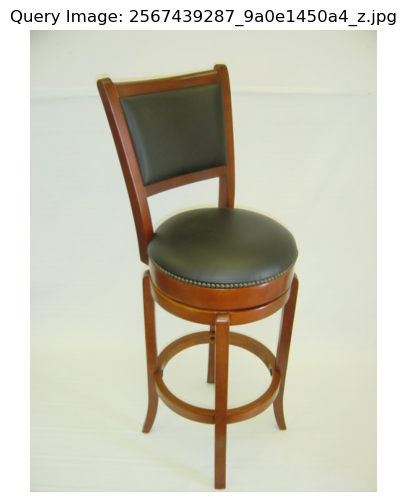

🔍 Query: dataset/unseen/AI22/2567439287_9a0e1450a4_z.jpg
📊 Top 5 similar images:
------------------------------------------------------------
1. Class: AI22
   Path: dataset/equipment_train/AI22/20251112_101934.jpg
   Confidence: 83.57% (Distance: 0.1643)

2. Class: AI22
   Path: dataset/equipment_train/AI22/20251112_101933.jpg
   Confidence: 83.15% (Distance: 0.1685)

3. Class: AI22
   Path: dataset/equipment_train/AI22/20251112_101945.jpg
   Confidence: 83.08% (Distance: 0.1692)

4. Class: AI22
   Path: dataset/equipment_train/AI22/20251112_101939.jpg
   Confidence: 82.67% (Distance: 0.1733)

5. Class: AI22
   Path: dataset/equipment_train/AI22/20251112_101937.jpg
   Confidence: 82.62% (Distance: 0.1738)

🎯 Predicted Class: AI22 (Confidence: 83.57%)


In [25]:
# Example 1: Search for a single image from testset
test_image_path = "dataset/unseen/AI22/2567439287_9a0e1450a4_z.jpg"
print("🔍 Single Image Search:")
results = search_similar_images_from_path(test_image_path, connection, top_k=5)

In [ ]:
# Example 2: Batch search multiple images from testset
print("\n" + "="*60)
print("🔍 Batch Search from Testset:")
batch_results = batch_search_from_folder("testset/", connection, top_k=3, max_images=5)

# Show summary of batch results
print("\n📊 Batch Search Summary:")
for filename, result in batch_results.items():
    if result:
        print(f"  {filename}: {result['predicted_class']} ({result['confidence']:.1f}%)")
    else:
        print(f"  {filename}: No results")

In [ ]:
# Example 3: Search with confidence threshold
print("\n" + "="*60)
print("🔍 High-Confidence Search:")
confidence_result = search_with_confidence_threshold(
    "testset/maltese.jpg", 
    connection, 
    confidence_threshold=75.0, 
    top_k=5
)

print(f"\nSearch Result Status: {confidence_result['status']}")
if confidence_result['status'] == 'confident':
    print(f"High-confidence prediction: {confidence_result['predicted_class']} ({confidence_result['confidence']:.1f}%)")
elif confidence_result['status'] == 'low_confidence':
    print(f"Low-confidence prediction: {confidence_result['predicted_class']} ({confidence_result['confidence']:.1f}%)")
    print(f"Message: {confidence_result['message']}")